In [21]:
import os

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

import sys
from datasets.ade20k import ADE10KDataset
from datasets.test import TestDataset
from models.unet import Unet
from PIL import Image, ImageOps, ImageFilter
from torchvision import models, datasets, transforms

print(sys.path)

%load_ext autoreload
%autoreload 2
%matplotlib inline

['C:\\Projects\\python\\netology\\Diploma\\notebooks', 'C:\\Projects\\python\\netology', 'C:\\Projects\\python\\netology\\Diploma', 'C:\\Users\\never\\miniconda3\\envs\\py39\\python39.zip', 'C:\\Users\\never\\miniconda3\\envs\\py39\\DLLs', 'C:\\Users\\never\\miniconda3\\envs\\py39\\lib', 'C:\\Users\\never\\miniconda3\\envs\\py39', '', 'C:\\Users\\never\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\never\\miniconda3\\envs\\py39\\lib\\site-packages', 'C:\\Users\\never\\miniconda3\\envs\\py39\\lib\\site-packages\\win32', 'C:\\Users\\never\\miniconda3\\envs\\py39\\lib\\site-packages\\win32\\lib', 'C:\\Users\\never\\miniconda3\\envs\\py39\\lib\\site-packages\\Pythonwin', 'C:\\Program Files\\JetBrains\\PyCharm 2021.2\\plugins\\python\\helpers\\pydev', 'C:\\Program Files\\JetBrains\\PyCharm 2021.2\\plugins\\python\\helpers-pro\\jupyter_debug']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1
True


In [23]:
ade20k = ADE10KDataset('../data/', full_dataset=False)

Text(0.5, 1.0, 'Segmentation')

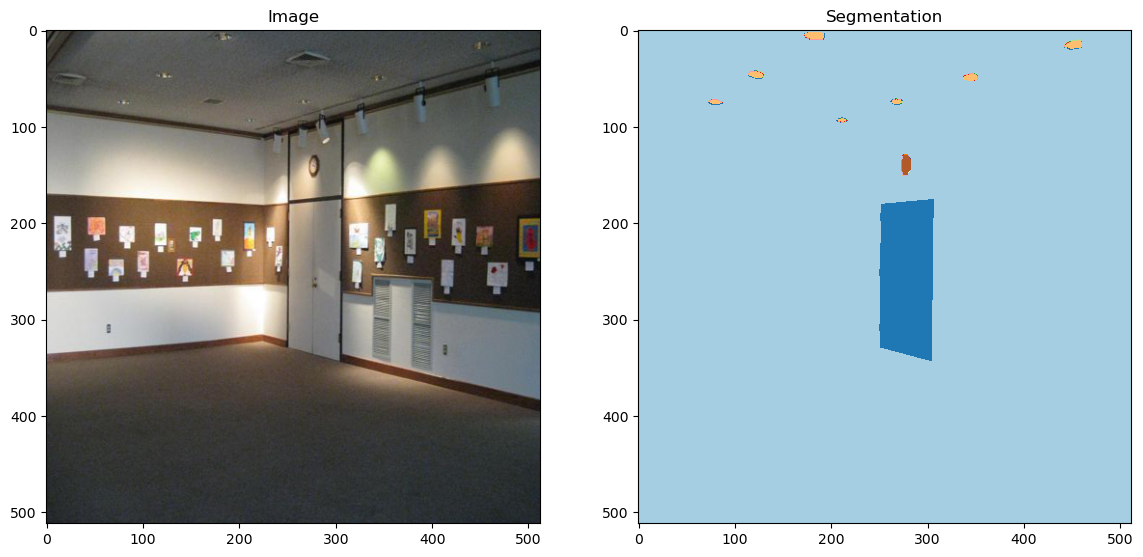

In [24]:
img, mask = ade20k[2]
img = img.numpy()
img = img.transpose(1, 2, 0)

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

In [25]:
img.shape, mask.shape

((512, 512, 3), torch.Size([512, 512]))

In [26]:
from operator import itemgetter
LABELS = ade20k.get_labels()
DESIRED_LABELS = itemgetter('floor', 'road', 'sidewalk', 'earth', 'rug', 'path', 'runway', 'dirt track', 'land')(LABELS)
DESIRED_LABELS


(4, 7, 12, 14, 29, 53, 55, 92, 95)

In [27]:
np.argwhere(np.isin(mask, DESIRED_LABELS)).T

array([[324, 324, 324, ..., 511, 511, 511],
       [214, 215, 216, ..., 509, 510, 511]], dtype=int64)

In [28]:
img.shape

(512, 512, 3)

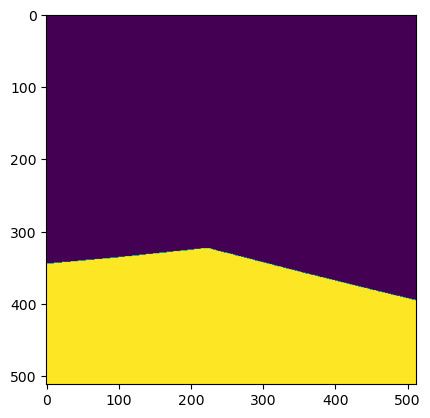

In [29]:
road = np.zeros((img.shape[0], img.shape[1]))
coords = np.argwhere(np.isin(mask, DESIRED_LABELS)).T
road[coords[0], coords[1]]=1

plt.imshow(road)

In [30]:
ade20k.get_labels()

{'wall': 1,
 'building': 2,
 'sky': 3,
 'floor': 4,
 'tree': 5,
 'ceiling': 6,
 'road': 7,
 'bed': 8,
 'windowpane': 9,
 'grass': 10,
 'cabinet': 11,
 'sidewalk': 12,
 'person': 13,
 'earth': 14,
 'door': 15,
 'table': 16,
 'mountain': 17,
 'plant': 18,
 'curtain': 19,
 'chair': 20,
 'car': 21,
 'water': 22,
 'painting': 23,
 'sofa': 24,
 'shelf': 25,
 'house': 26,
 'sea': 27,
 'mirror': 28,
 'rug': 29,
 'field': 30,
 'armchair': 31,
 'seat': 32,
 'fence': 33,
 'desk': 34,
 'rock': 35,
 'wardrobe': 36,
 'lamp': 37,
 'bathtub': 38,
 'railing': 39,
 'cushion': 40,
 'base': 41,
 'box': 42,
 'column': 43,
 'signboard': 44,
 'chest of drawers': 45,
 'counter': 46,
 'sand': 47,
 'sink': 48,
 'skyscraper': 49,
 'fireplace': 50,
 'refrigerator': 51,
 'grandstand': 52,
 'path': 53,
 'stairs': 54,
 'runway': 55,
 'case': 56,
 'pool table': 57,
 'pillow': 58,
 'screen door': 59,
 'stairway': 60,
 'river': 61,
 'bridge': 62,
 'bookcase': 63,
 'blind': 64,
 'coffee table': 65,
 'toilet': 66,
 'flow

In [58]:
path = "../data/models/unet_256x256_10ep_aug_25-08-23_1806.pth"
model = torch.load(path)
model.eval()

Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [66]:
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ade20k = ADE10KDataset('../data/', mode='validation', base_size=256)
image1, _ = ade20k[150]
x = image1.to(device)

# output = model(x.float().unsqueeze(0))
#
# probs = torch.nn.functional.softmax(output, dim=1)
# print(probs.shape)
# conf, classes = torch.max(probs, 1)
# conf, classes, output

with torch.no_grad():
    output = model(x.float().unsqueeze(0)).cpu()
    output = F.interpolate(output, (image1.shape[1], image1.shape[2]), mode='bilinear')
    if model.n_classes > 1:
        mask = output.argmax(dim=1)
    else:
        mask = torch.sigmoid(output) > 0.5

mask1 = mask[0].long().squeeze().numpy()

Text(0.5, 1.0, 'Segmentation')

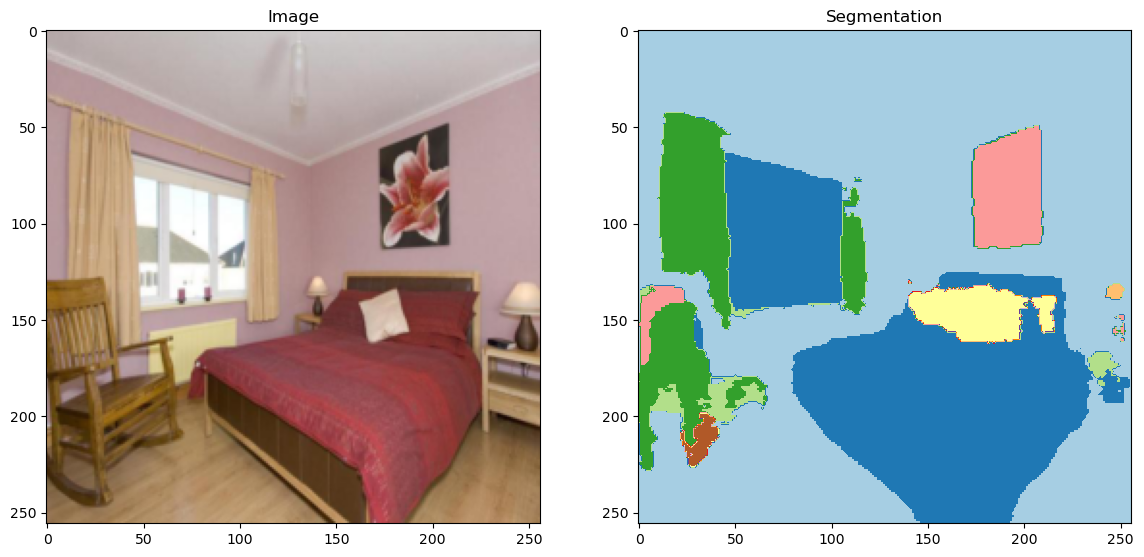

In [67]:
coords = np.argwhere(np.isin(mask1, DESIRED_LABELS)).T
road = np.zeros((mask1.shape[0], mask1.shape[1]))
road[coords[0], coords[1]]=1
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(image1.numpy().transpose(1, 2, 0))
arr[0].set_title('Image')
arr[1].imshow(mask1, cmap='Paired')
arr[1].set_title('Segmentation')

#### Примеры работы сетей

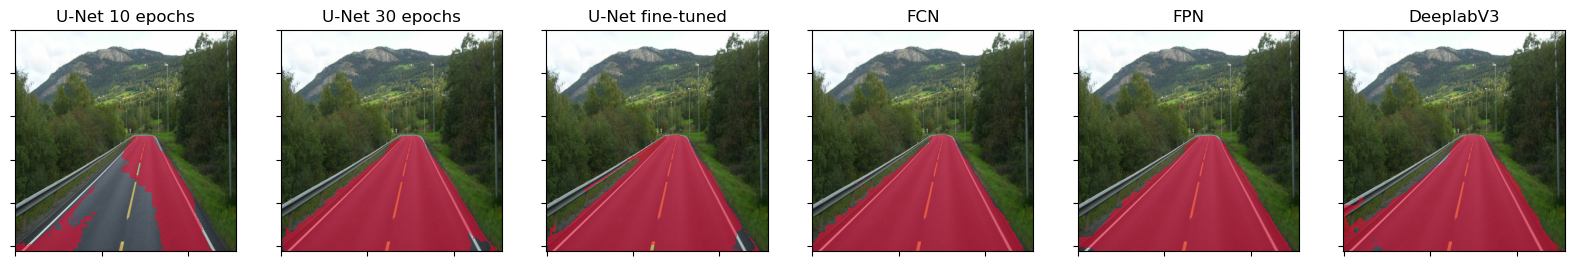

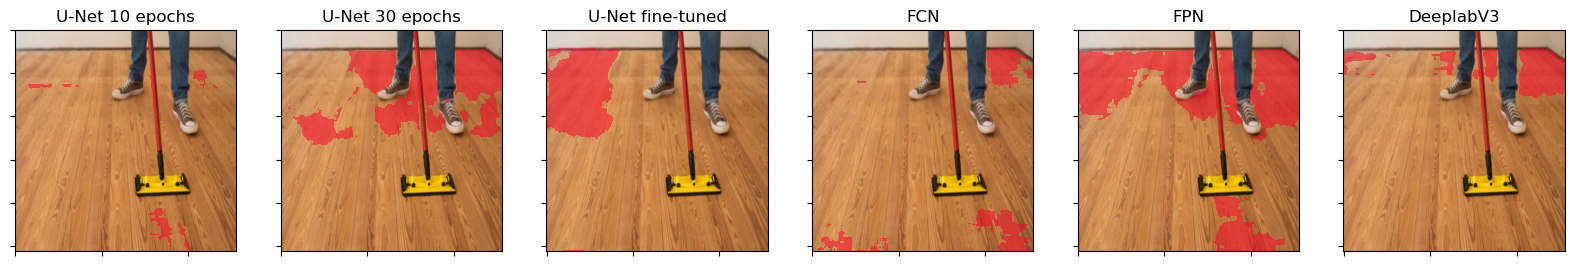

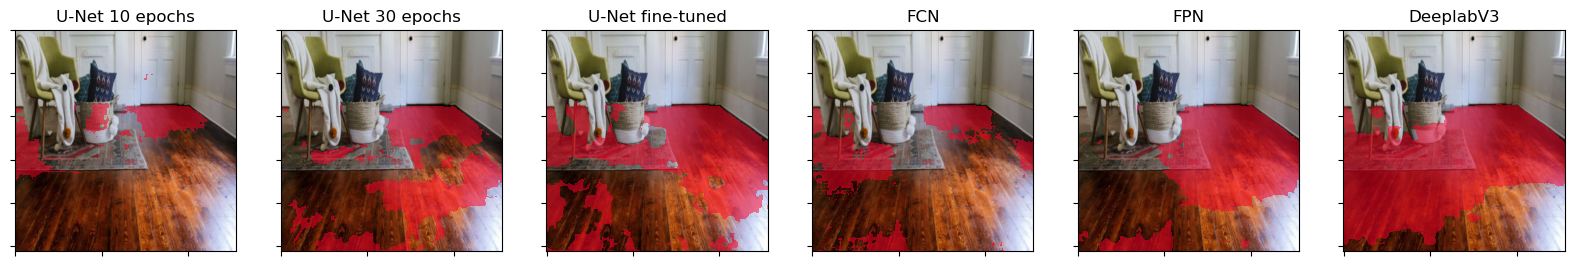

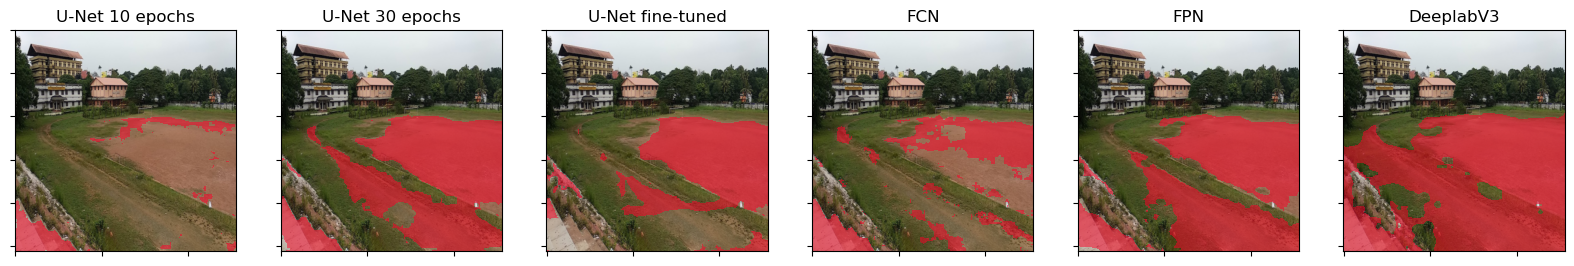

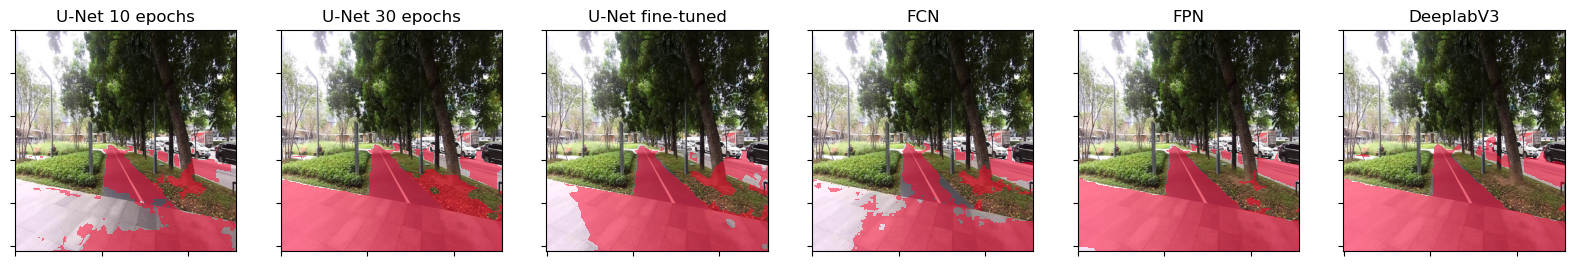

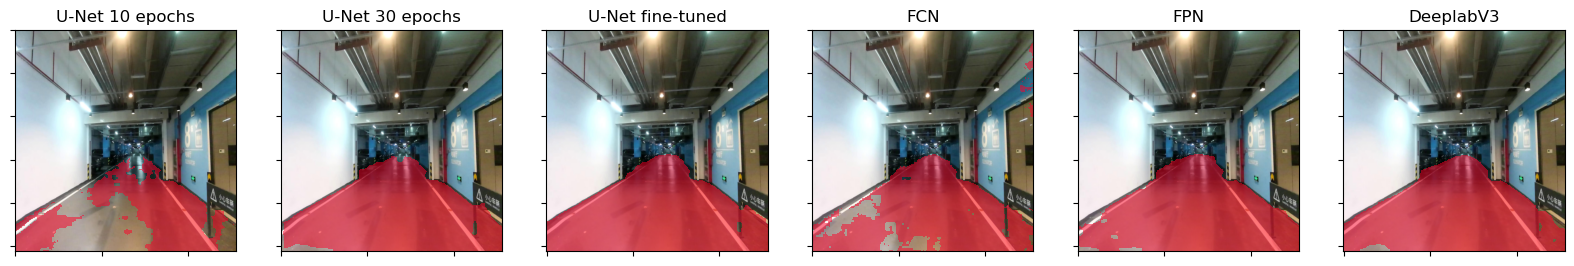

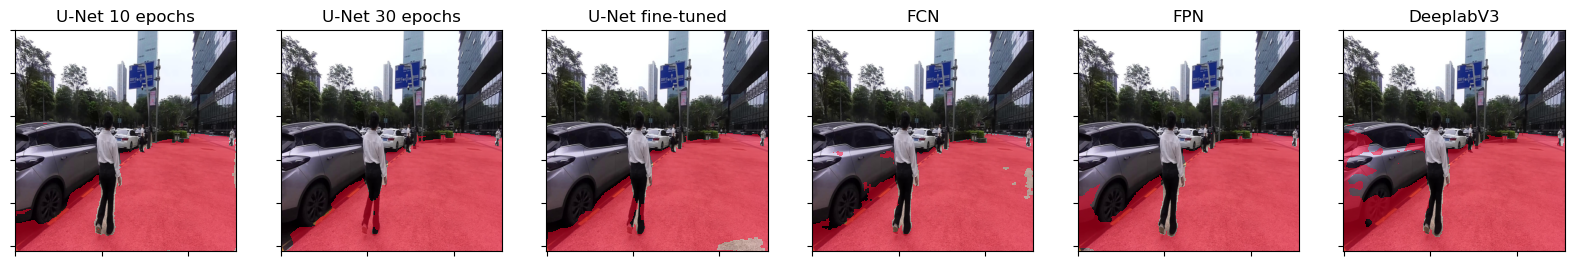

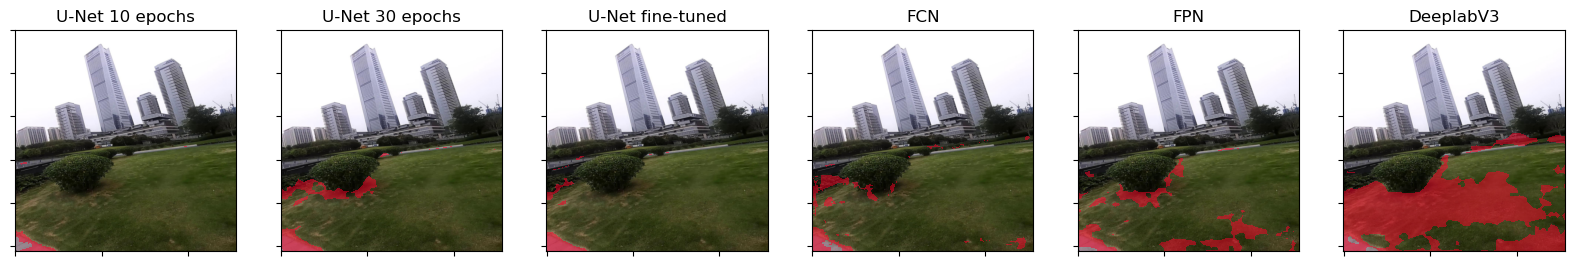

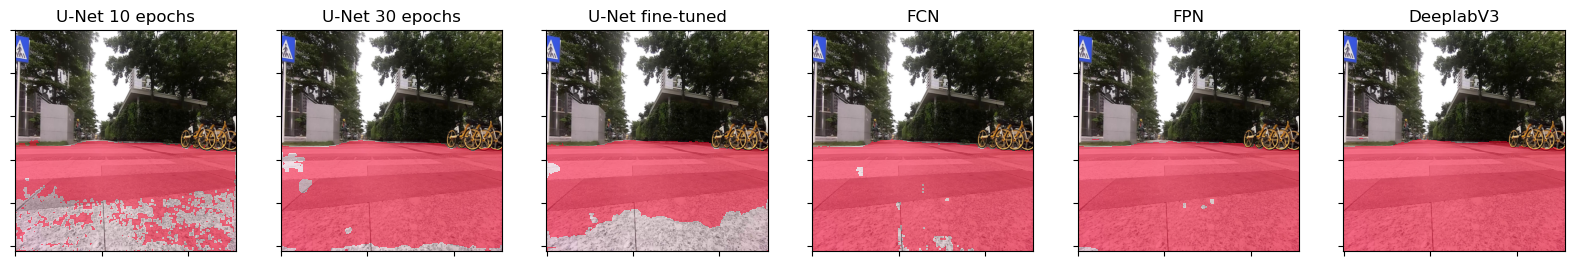

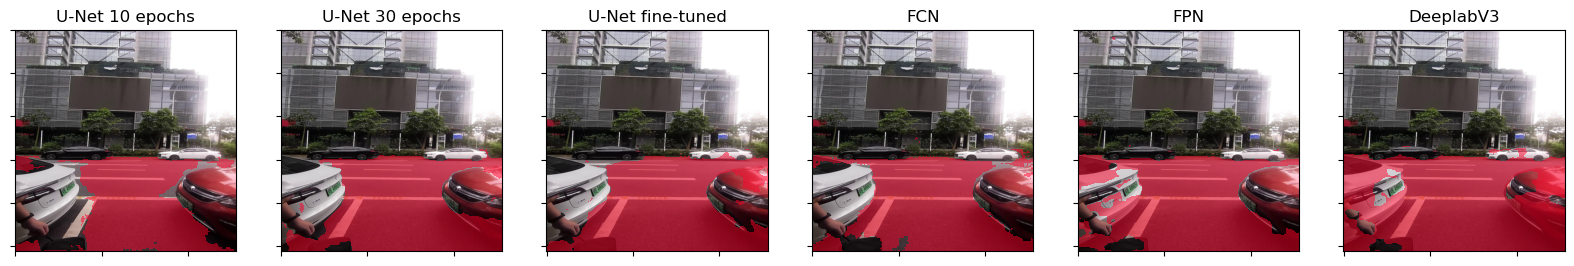

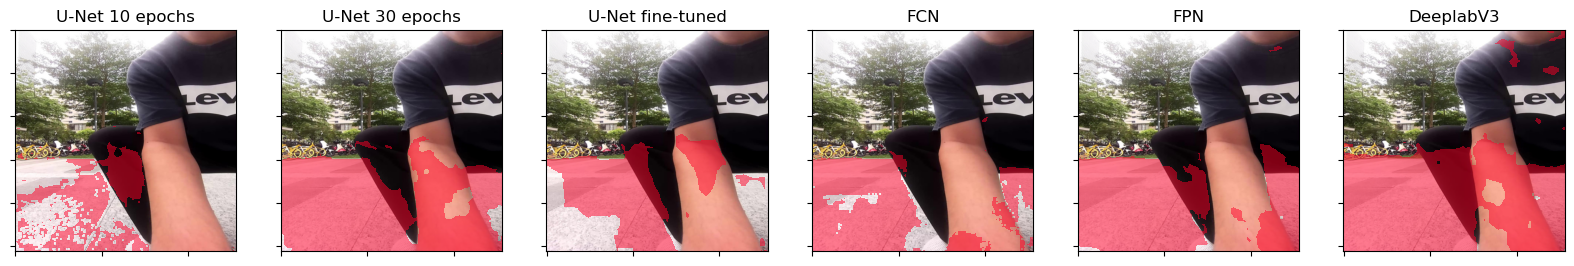

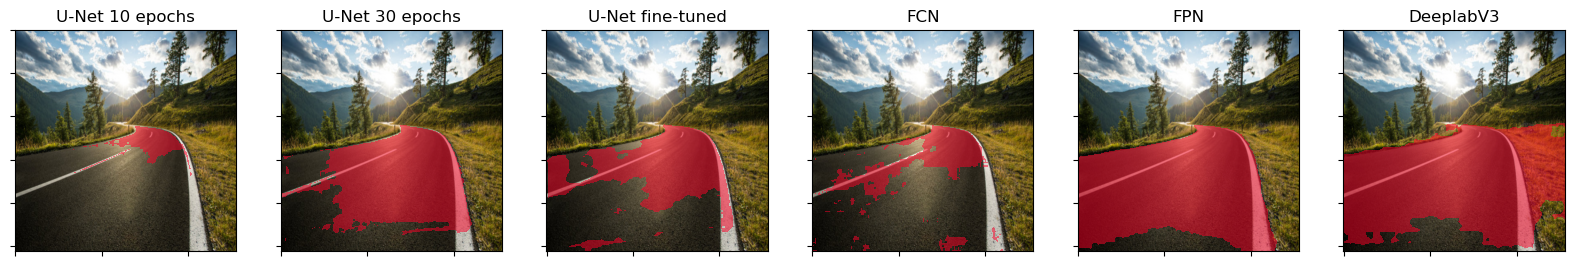

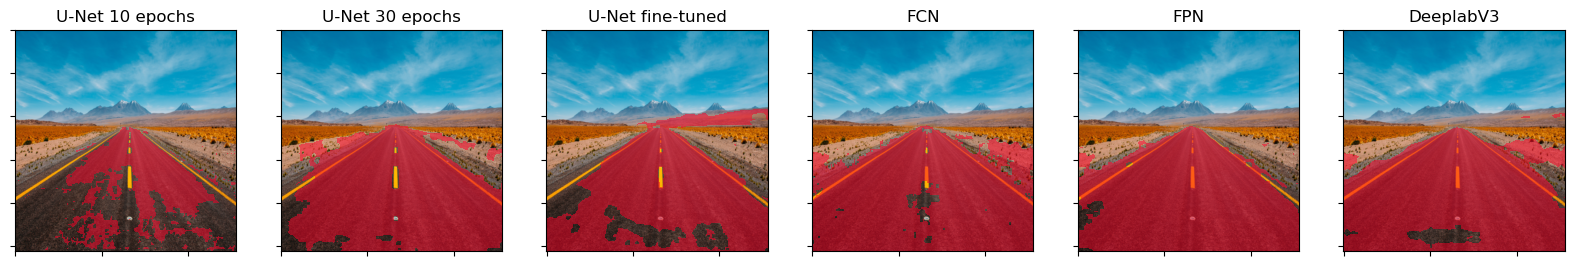

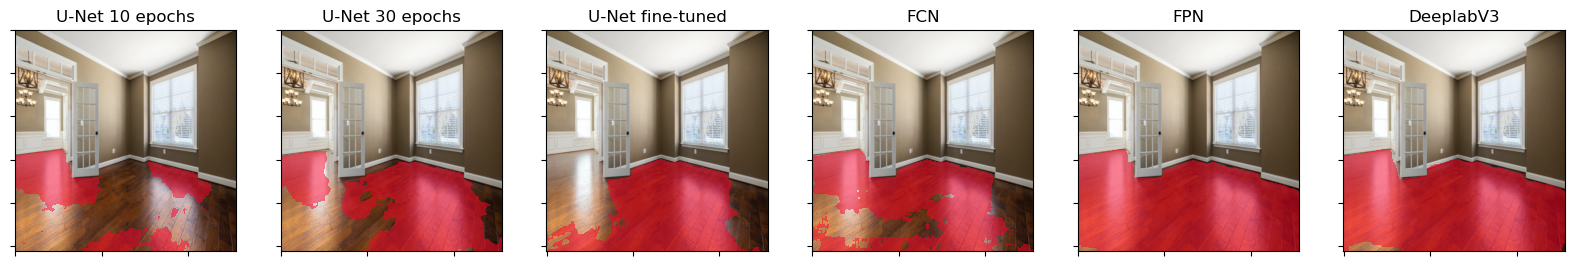

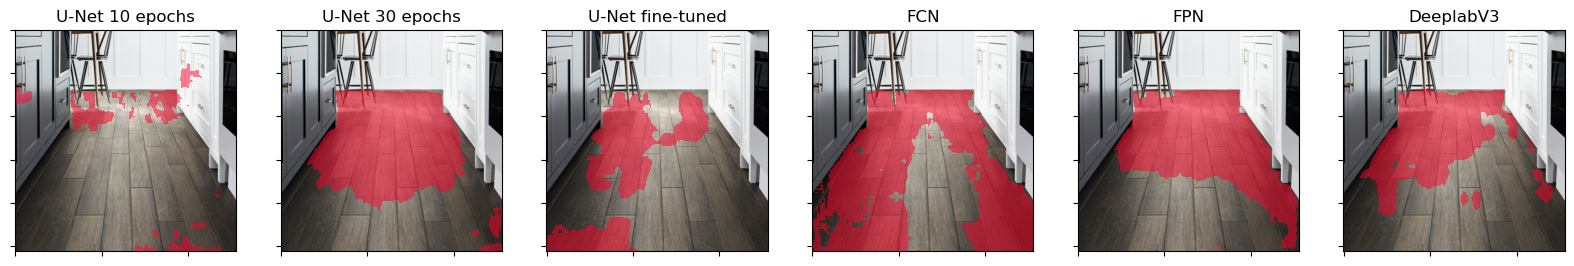

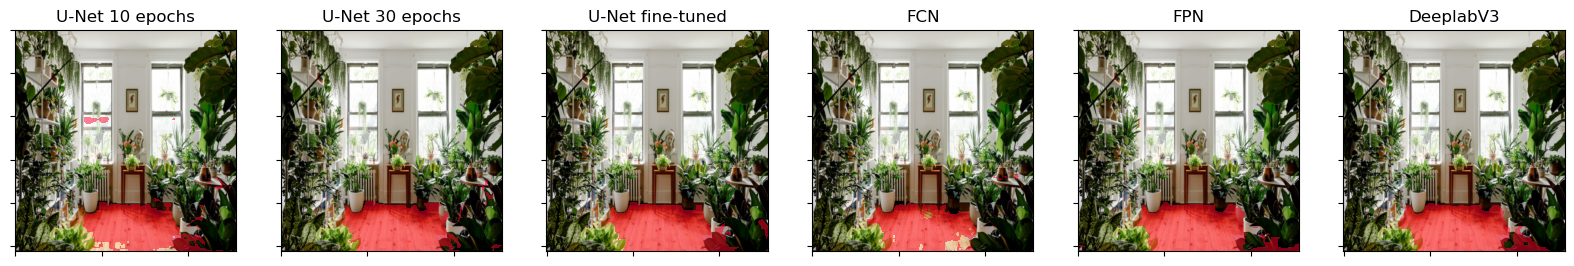

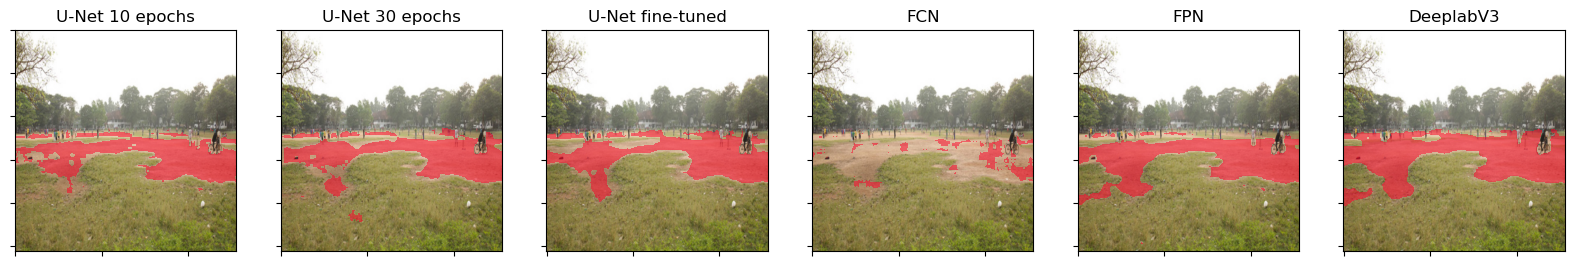

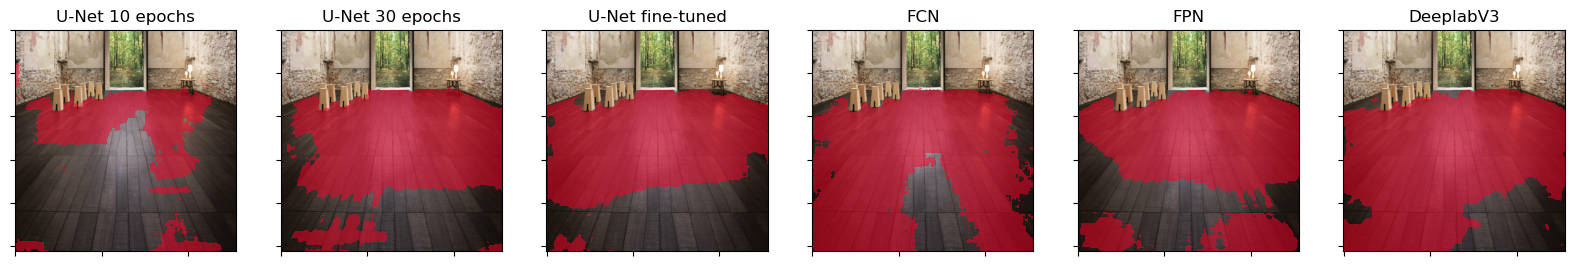

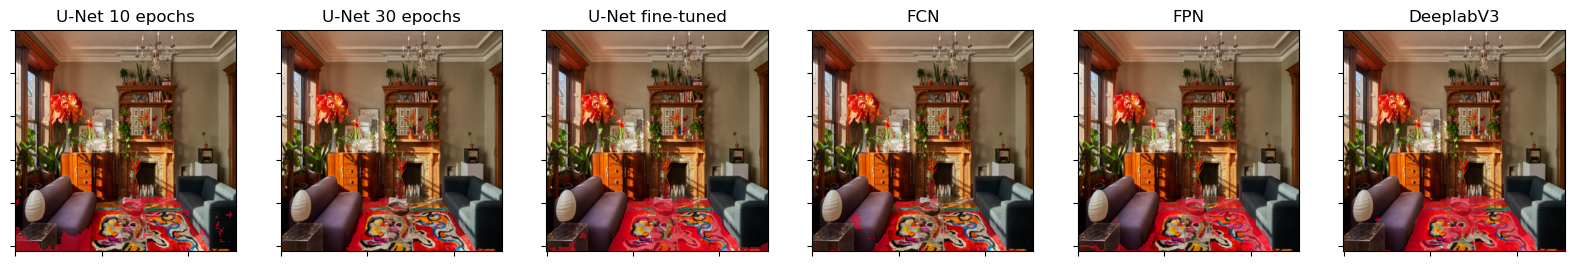

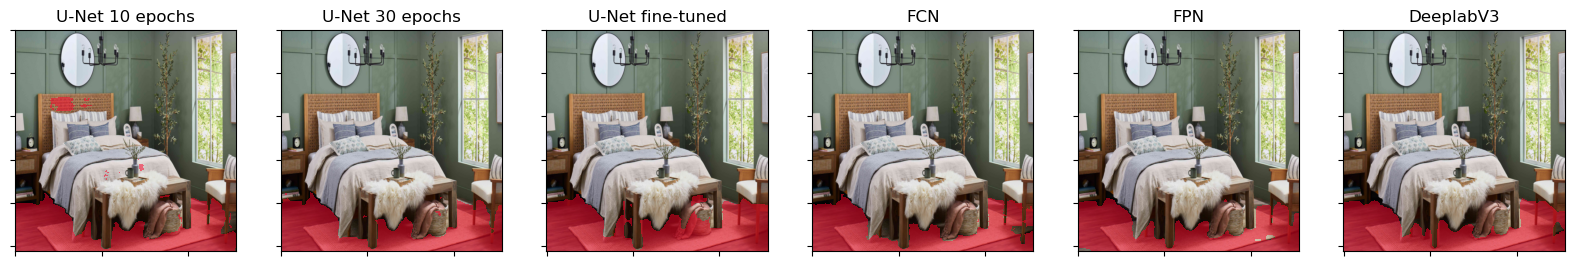

In [71]:
from scripts.predict import predict
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DESIRED_LABELS = (4, 7, 12, 14, 29, 53, 55, 92, 95)
ROOT_PATH = '../data'

unet_10_path = "../data/models/unet_256x256_10ep_aug_25-08-23_1806.pth"
unet_30_path = "../data/models/unet_256x256_30ep_aug_26-08-23_0557.pth"
unet_ft_path = "../data/models/unet_256x256_10ep_aug_25-08-23_2002.pth"
fcn_path = "../data/models/fcn8s_256x256_10ep_aug_25-08-23_2201.pth"
fpn_path = "../data/models/fpn_256x256_10ep_aug_25-08-23_2323.pth"
deeplab_path = "../data/models/deeplabv3_256x256_10ep_aug_26-08-23_0139.pth"
nets = {
    'U-Net 10 epochs': unet_10_path,
    'U-Net 30 epochs': unet_30_path,
    'U-Net fine-tuned': unet_ft_path,
    'FCN': fcn_path,
    'FPN': fpn_path,
    'DeeplabV3': deeplab_path,
}

for key in nets:
    nets[key] = torch.load(nets[key])
    nets[key].to(device)

nets_length = len(nets)
data = TestDataset("../data/")
for img in data:
    img_to_show = np.transpose(img.numpy(), (1, 2, 0))
    fig, axes = plt.subplots(1, nets_length, figsize=(20, 10))
    # fig, axes = plt.subplots(2, nets_length // 2, figsize=(17, 12))
    # axes = axes.flatten()

    for i, key in enumerate(nets):
        mask = predict(nets[key], img, device)

        # arr[0].imshow(img)
        # arr[0].set_title('Image')
        # arr[1].imshow(mask, cmap='Paired')
        # arr[1].set_title('Segmentation')

        mask[mask == 0] = 'nan'

        axes[i].set_title(key)
        axes[i].set_yticklabels([])
        axes[i].set_xticklabels([])
        axes[i].imshow(img_to_show)
        axes[i].imshow(mask, cmap='gist_rainbow', alpha=0.5)
plt.show()